#                            Stock Analysis and Price Prediction

# Contents
    1. Introduction
    2. Importing libraries
    3. Reading datasets
    4. Building Models
    5. Conclusion

# Introduction
In this project we will show how to write a python program that predicts the price of stocks using a machine learning technique called Long Short-Term Memory (LSTM) as well as create a optimize portfoilo using Efficient Frontier.

We will be solve the following question:

1. What was the change in price of the stock over time?
2. What was the daily return of the stock on average?
3. What was the moving average of the various stocks?
4. What was the correlation between different stocks'?
5. How much value do we put at risk by investing in a particular stock?
6. Portfoilo optimization using Efficient Frontier?
7. How can we attempt to predict future stock behavior using LSTM?

# Importing Libraries

In [5]:
# here we are importing important libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from pandas_datareader import data as web

plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
%matplotlib inline

In [35]:
# # Here we are making tech list which we will use for this analysis
# Tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
# # now we are setting end and start time for grabing data
# end = datetime.now()
# start = datetime(end.year-5,end.month,end.day)
# # now we are using for loop for grabing yahoo data and setting it in form of dataframe
# #  Using globals() is a sloppy way of setting the DataFrame names, but its simple

# for stock in Tech_list:
#     globals()[stock] = web.DataReader(stock,"yahoo",start,end)
    

In [6]:
# # here we are making list of our company
# Company_list = [AAPL,GOOG,MSFT,AMZN]
# company_name = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
# for company, comp_name in zip(Company_list,company_name):
#     company["company_name"] = comp_name
    
# df = pd.concat(Company_list,axis=0)
# df

# Reading Dataset

Companies names and thier Ticker that we used for our Analysis
    
    1. Apple Inc. = AAPL
    2. Alphabet Inc. = GOOG
    3. Microsoft Corporation = MSFT
    4. Amazon = AMZN
    5. Facebook Inc. = FB
    6. Alibaba Group = BABA
    7. Johnson & Johnson = JNJ
    8. JPMorgon Chase & Co. = JPM
    9. ExxonMobil = XOM
    10.Bank of America = BAC
    11.WalMart Store Inc. = WMT
    12.Wells Fargo & Co. = WFC
    13.Visa Inc. = V
    14.Procter & Gamble Co. = PG
    15.Verizon Communication = VZ
    16.AT&T Inc. = T
    17.UnitedHealth Group Inc. = UNH
    18.Home Depot = HD
    19.Intel = INTC
    20.Oracle = ORCL


In [14]:
#List of ticker of companies
Tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'FB', 'BABA','JNJ', 'JPM', 'XOM', 'BAC', 'WMT', 'WFC', 'V', 'PG', 'VZ', 'T', 'UNH', 'HD', 'INTC', 'ORCL']
data = pdr.get_data_yahoo(Tech_list, start = '2015-01-01')
data

Attributes   Adj Close                                                    \
Symbols           AAPL         GOOG        MSFT         AMZN          FB   
Date                                                                       
2015-01-02   24.941502   523.373108   41.647892   308.519989   78.449997   
2015-01-05   24.238857   512.463013   41.264908   302.190002   77.190002   
2015-01-06   24.241146   500.585632   40.659245   295.290009   76.150002   
2015-01-07   24.581060   499.727997   41.175831   298.420013   76.150002   
2015-01-08   25.525522   501.303680   42.387146   300.459991   78.180000   
...                ...          ...         ...          ...         ...   
2020-10-30  108.860001  1621.010010  202.470001  3036.149902  263.109985   
2020-11-02  108.769997  1626.030029  202.330002  3004.479980  261.359985   
2020-11-03  110.440002  1650.209961  206.429993  3048.409912  265.299988   
2020-11-04  114.949997  1749.130005  216.389999  3241.159912  287.380005   
2020-11-05  119.029999  1763.369995  223.289993  3322.000000  294.679993   

Attributes                                                            ...  \
Symbols           BABA         JNJ         JPM        XOM        BAC  ...   
Date                                                                  ...   
2015-01-02  103.599998   89.316841   52.891674  72.572495  16.126829  ...   
2015-01-05  101.000000   88.693039   51.249664  70.586792  15.658340  ...   
2015-01-06  103.320000   88.257210   49.920807  70.211517  15.189854  ...   
2015-01-07  102.129997   90.205597   49.996979  70.922943  15.261930  ...   
2015-01-08  105.029999   90.914841   51.114243  72.103416  15.577259  ...   
...                ...         ...         ...        ...        ...  ...   
2020-10-30  304.690002  137.110001   98.040001  32.619999  23.700001  ...   
2020-11-02  310.839996  138.690002  100.250000  33.990002  24.080000  ...   
2020-11-03  285.570007  138.500000  103.410004  33.410000  24.690001  ...   
2020-11-04  295.709991  139.399994  100.250000  33.230000  23.680000  ...   
2020-11-05  287.750000  139.759995  104.349998  33.169998  24.610001  ...   

Attributes      Volume                                                 \
Symbols            WMT         WFC           V         PG          VZ   
Date                                                                    
2015-01-02   4501800.0  11700900.0   8389600.0  7251400.0  11421200.0   
2015-01-05   6979000.0  15000500.0  12751200.0  8626100.0  18964500.0   
2015-01-06   8205100.0  20211200.0  11070000.0  7791200.0  22950100.0   
2015-01-07   8498400.0  15714700.0   9346800.0  5986600.0  20793600.0   
2015-01-08  12713600.0  16721600.0  10443200.0  6823300.0  17617500.0   
...                ...         ...         ...        ...         ...   
2020-10-30   6200600.0  34592400.0  10252900.0  6422000.0  17632800.0   
2020-11-02   5525200.0  38401200.0   8057100.0  6682800.0  16086400.0   
2020-11-03   5137700.0  38427000.0   6467900.0  6244200.0  10693500.0   
2020-11-04   5970900.0  47186600.0   8098900.0  5818000.0  20780600.0   
2020-11-05   4186587.0  37934718.0   6937758.0  5311479.0  19384553.0   

Attributes                                                             
Symbols              T         UNH         HD        INTC        ORCL  
Date                                                                   
2015-01-02  20564000.0   3060900.0  4323700.0  23605600.0  15070200.0  
2015-01-05  30429100.0   4679000.0  5878100.0  32785000.0  18369400.0  
2015-01-06  29595800.0   3468300.0  4910100.0  30847600.0  19229500.0  
2015-01-07  31660000.0   3225800.0  5091000.0  27725200.0  13502200.0  
2015-01-08  22799800.0   5346100.0  6464600.0  31765400.0  17516900.0  
...                ...         ...        ...         ...         ...  
2020-10-30  48421200.0   3556800.0  3872800.0  46781300.0  12602300.0  
2020-11-02  48052100.0   4519000.0  2956400.0  33856700.0  11413200.0  
2020-11-03  33284900.0   4043900.0  30375

In [15]:
#Getting column name
my_list = list(data)

print (my_list)

[('Adj Close', 'AAPL'), ('Adj Close', 'GOOG'), ('Adj Close', 'MSFT'), ('Adj Close', 'AMZN'), ('Close', 'AAPL'), ('Close', 'GOOG'), ('Close', 'MSFT'), ('Close', 'AMZN'), ('High', 'AAPL'), ('High', 'GOOG'), ('High', 'MSFT'), ('High', 'AMZN'), ('Low', 'AAPL'), ('Low', 'GOOG'), ('Low', 'MSFT'), ('Low', 'AMZN'), ('Open', 'AAPL'), ('Open', 'GOOG'), ('Open', 'MSFT'), ('Open', 'AMZN'), ('Volume', 'AAPL'), ('Volume', 'GOOG'), ('Volume', 'MSFT'), ('Volume', 'AMZN')]


In [15]:
# Getting Adj Close of all companies
aclose = data['Adj Close']
aclose

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.941502,523.373108,41.647892,308.519989,78.449997,103.599998,89.316841,52.891674,72.572495,16.126829,74.438179,45.060791,63.224792,75.385979,35.858070,24.135557,91.983253,90.742973,31.082489,40.292976
2015-01-05,24.238857,512.463013,41.264908,302.190002,77.190002,101.000000,88.693039,51.249664,70.586792,15.658340,74.221535,43.825119,61.829178,75.027550,35.560268,23.907534,90.468170,88.839142,30.732008,39.727905
2015-01-06,24.241146,500.585632,40.659245,295.290009,76.150002,103.320000,88.257210,49.920807,70.211517,15.189854,74.793457,42.910725,61.430756,74.685783,35.919155,23.943163,90.285606,88.567192,30.159252,39.317783
2015-01-07,24.581060,499.727997,41.175831,298.420013,76.150002,102.129997,90.205597,49.996979,70.922943,15.261930,76.777901,43.166092,62.253826,75.077545,35.687363,23.972069,91.207451,91.602760,30.791851,39.326889
2015-01-08,25.525522,501.303680,42.387146,300.459991,78.180000,105.029999,90.914841,51.114243,72.103416,15.577259,78.398384,44.121681,63.088814,75.936104,36.452274,24.210564,95.561104,93.629402,31.364601,39.563850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-30,108.860001,1621.010010,202.470001,3036.149902,263.109985,304.690002,137.110001,98.040001,32.619999,23.700001,138.750000,21.351967,181.710007,137.100006,56.990002,27.020000,305.140015,266.709991,44.279999,56.110001
2020-11-02,108.769997,1626.030029,202.330002,3004.479980,261.359985,310.839996,138.690002,100.250000,33.990002,24.080000,140.399994,21.799908,184.740005,138.500000,57.700001,27.340000,312.100006,270.739990,44.459999,56.450001
2020-11-03,110.440002,1650.209961,206.429993,3048.409912,265.299988,285.570007,138.500000,103.410004,33.410000,24.690001,142.779999,21.989040,188.339996,141.220001,57.750000,27.459999,321.350006,277.369995,44.849998,56.799999


In [19]:
#Here is quick summary of each company Adjusted closing
aclose.describe()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,44.857623,989.105530,93.830586,1330.899715,155.347318,147.004861,117.014338,84.440658,65.535154,22.359736,85.662813,44.164022,119.353602,87.507747,46.245796,29.482301,195.305895,162.416153,40.443059,44.875537
std,22.825387,285.893280,50.269588,746.964657,48.182655,57.955117,19.763665,23.497541,10.232445,6.357645,23.836235,7.674179,45.978911,20.986261,7.334077,3.211221,67.740012,50.311560,10.985731,7.221417
min,21.202499,491.201416,35.983208,286.950012,74.050003,57.389999,79.246399,46.027359,30.254938,10.177327,49.833813,21.043383,58.773144,58.065460,33.866959,23.574585,90.285606,88.567192,22.621140,31.409939
25%,27.664633,749.429993,50.792519,719.299988,117.290001,87.580002,102.000092,58.159439,64.827957,15.348064,64.924042,42.476078,76.417282,72.018265,40.347969,27.278740,127.299698,118.340996,30.811340,38.140831
50%,38.879524,1020.080017,80.857437,1162.349976,159.389999,156.279999,121.223618,89.200592,68.734856,23.350195,80.962029,46.042427,110.156471,79.099525,43.821190,29.348173,206.367462,160.333832,41.680275,45.437508
75%,51.379974,1184.650024,125.813942,1813.030029,185.169998,185.250000,131.715500,102.432304,71.786217,27.803112,100.712578,48.546276,160.085129,102.136841,53.532459,31.547754,248.531860,194.655273,49.189999,51.225140
max,134.179993,1763.369995,231.649994,3531.449951,303.910004,317.140015,153.830002,136.145889,78.264053,34.925472,147.679993,59.205624,216.479996,143.692154,59.971466,37.092419,354.559998,290.398560,67.294716,61.459999


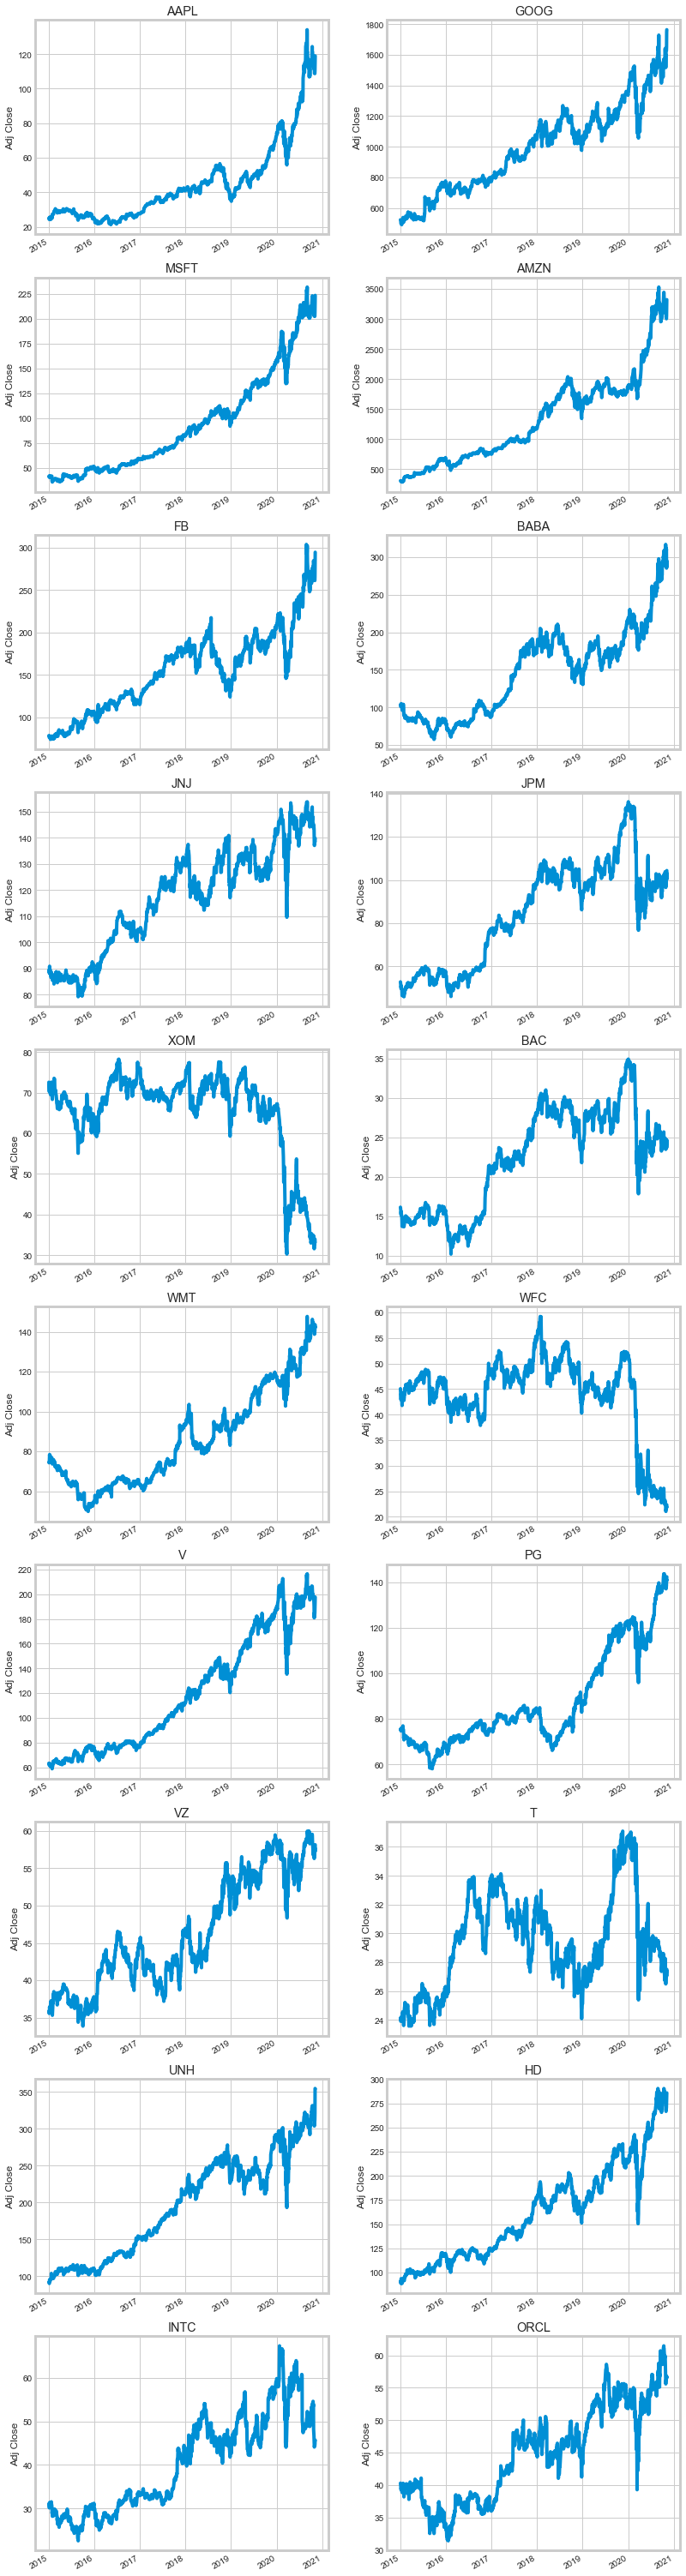

In [76]:
# here we are visualising of closing price

plt.figure(figsize=(12, 20))
plt.subplots_adjust(top=2.25, bottom=2.2)

columns = list(aclose) 
  
for i, cols in enumerate(columns,1):
    plt.subplot(10, 2,i)
    aclose[cols].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"{Tech_list[i - 1]}")

In [77]:
# Calculating daily percentage change
daily_returns = data['Adj Close'].pct_change()
daily_returns.tail()

Symbols,AAPL,GOOG,MSFT,AMZN,FB,BABA,JNJ,JPM,XOM,BAC,WMT,WFC,V,PG,VZ,T,UNH,HD,INTC,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2020-10-30,-0.056018,0.034309,-0.010991,-0.054456,-0.063099,-0.025179,-0.000583,0.008953,-0.010616,0.006797,-0.008362,0.014664,-0.017093,-0.003416,0.004052,0.009716,0.004808,-0.010830,0.003854,0.001607
2020-11-02,-0.000827,0.003097,-0.000691,-0.010431,-0.006651,0.020184,0.011524,0.022542,0.041999,0.016034,0.011892,0.020979,0.016675,0.010211,0.012458,0.011843,0.022809,0.015110,0.004065,0.006060
2020-11-03,0.015354,0.014871,0.020264,0.014621,0.015075,-0.081296,-0.001370,0.031521,-0.017064,0.025332,0.016952,0.008676,0.019487,0.019639,0.000867,0.004389,0.029638,0.024488,0.008772,0.006200
2020-11-04,0.040837,0.059944,0.048249,0.063230,0.083227,0.035508,0.006498,-0.030558,-0.005388,-0.040907,-0.005743,-0.009507,0.029893,-0.004107,-0.009177,-0.015295,0.103345,0.019288,0.018952,-0.005458
2020-11-05,0.035494,0.008141,0.031887,0.024942,0.025402,-0.026918,0.002583,0.040898,-0.001806,0.039274,0.010637,0.025253,0.018920,0.012372,0.016253,0.017382,-0.000451,0.011071,-0.000438,0.003009


In [123]:
avg = daily_returns.mean()
avg

Symbols
AAPL    0.001238
GOOG    0.000971
MSFT    0.001297
AMZN    0.001806
FB      0.001104
BABA    0.000908
JNJ     0.000379
JPM     0.000627
XOM    -0.000390
BAC     0.000505
WMT     0.000543
WFC    -0.000285
V       0.000904
PG      0.000508
VZ      0.000397
T       0.000185
UNH     0.001075
HD      0.000904
INTC    0.000466
ORCL    0.000359
dtype: float64

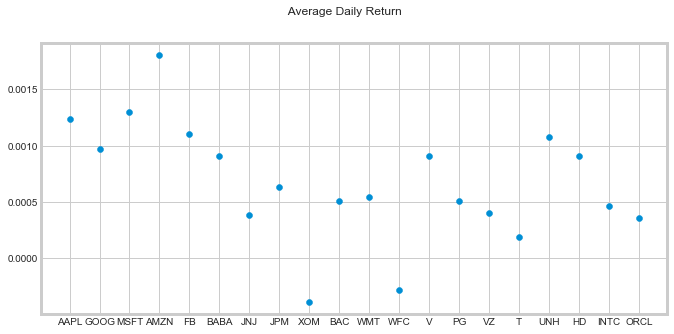

In [137]:
plt.figure(figsize=(10, 5))
plt.scatter(columns, avg)
plt.suptitle(' Average Daily Return')
plt.show()

In [127]:
top_five = avg.nlargest(5)
top_five

Symbols
AMZN    0.001806
MSFT    0.001297
AAPL    0.001238
FB      0.001104
UNH     0.001075
dtype: float64

In [128]:
name = list(top_five.keys())
name

['AMZN', 'MSFT', 'AAPL', 'FB', 'UNH']

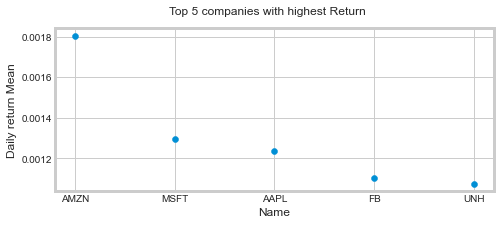

In [141]:
plt.figure(figsize=(7, 3))
plt.scatter(name, top_five)
plt.suptitle('Top 5 companies with highest Return')
plt.ylabel('Daily return Mean')
plt.xlabel('Name')
plt.show()